In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
from src.settings import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx
from keplergl import KeplerGl
from src.tools.feature_extraction import FEATURESET
from src.tools.aggregation import aggregate_hex

In [3]:
tqdm.pandas()

In [4]:
# place_name = "Berlin,Germany"
# place_dir_name = get_place_dir_name(place_name)
# resolution = 9
# buffered = True

# edges_hex = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
# hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
# edges_shp = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, "shp_drive", f"edges_hex_{get_resolution_buffered_suffix(resolution, buffered)}.shp")).set_index("h3_id")
# edges = edges_hex.groupby("id").first().drop(columns="h3_id").reset_index()

In [5]:
cities = pd.read_csv(RAW_DATA_DIR.joinpath("cities.csv"))
cities = cities[cities["country"] == "Poland"]
cities: pd.DataFrame = cities[cities["city"] != "Świdnica"].reset_index(drop=True)
cities

,city,country
0,Wrocław,Poland
1,Warszawa,Poland
2,Kraków,Poland
3,Poznań,Poland
4,Gdańsk,Poland
5,Szczecin,Poland
6,Katowice,Poland
7,Częstochowa,Poland
8,Białystok,Poland


In [6]:
resolution = 9
buffered = True
network_type = "drive"

pbar = tqdm(cities.itertuples(), total=cities.shape[0])
edges_hex_cities = []
hexagons_cities = []
for row in pbar:
    place_name = f"{row.city},{row.country}"
    place_dir_name = get_place_dir_name(place_name)
    pbar.set_description(place_name)

    hexagon_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    hexagon_city["city"] = row.city
    hexagons_cities.append(hexagon_city)

    edges_hex_city = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_{network_type}_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
    edges_hex_city["city"] = row.city
    edges_hex_cities.append(edges_hex_city)

hexagons = pd.concat(hexagons_cities, ignore_index=True).set_index("h3_id")
edges = pd.concat(edges_hex_cities, ignore_index=True)
hex_agg = aggregate_hex(edges.drop(columns="city"))

del edges_hex_cities
del hexagons_cities

Białystok,Poland: 100%|██████████| 9/9 [01:35<00:00, 10.66s/it]


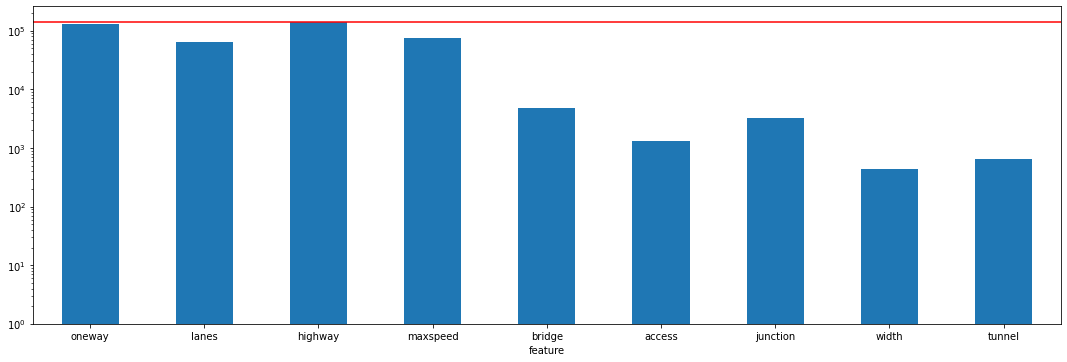

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
counts = []
plt.tight_layout()
for i, feature in enumerate(FEATURESET.keys()):
    columns = [x for x in edges.columns if feature in x]
    counts.append(edges[columns].sum().sum())
df_to_plot = pd.DataFrame(data={"feature": list(FEATURESET.keys()), "count": counts }).set_index("feature")
df_to_plot.plot(kind="bar", ax=ax, title="", rot=0, legend=False, xlabel="feature", log=True)
ax.axes.axhline(len(edges.index), color="red")
plt.show()

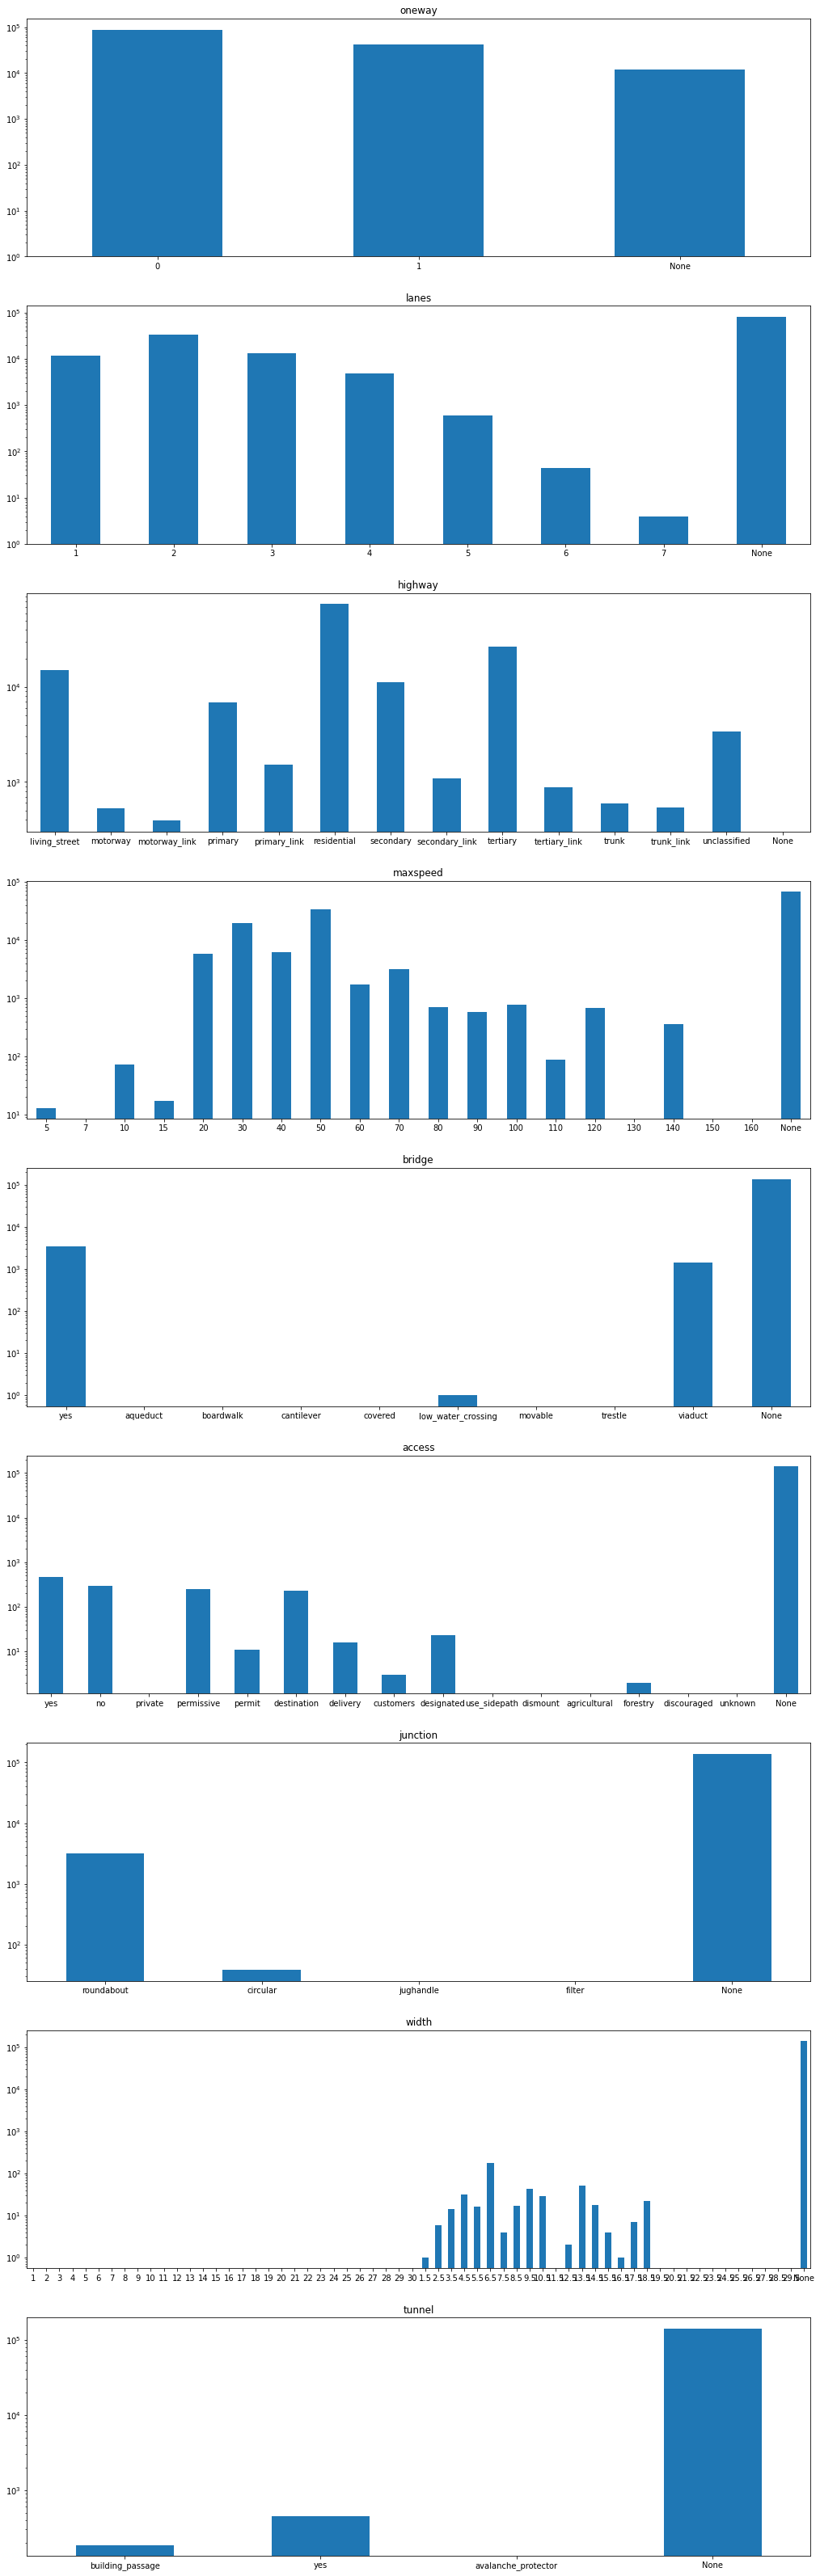

In [8]:
n = len(FEATURESET)

fig, axs = plt.subplots(n, figsize=(15, 5 * n))
plt.tight_layout(pad=4)
for i, feature in enumerate(FEATURESET.keys()):
    columns = [x for x in edges.columns if feature in x]
    df_to_plot = edges[columns].rename(columns={column: "_".join(column.split("_")[1:]) for column in columns}).sum()
    df_to_plot["None"] = len(edges.index) - df_to_plot.sum()
    df_to_plot.plot(kind="bar", ax=axs[i], title=feature, rot=0, log=True)
plt.show()

In [10]:
from src.tools.feature_extraction import melt_and_max

df_agg = edges.copy()
for column_name in ["oneway", "lanes", "maxspeed", "width"]:
    columns = [x for x in edges.columns if column_name in x]
    df_agg = df_agg.join(melt_and_max(edges, column_name, columns), on="id")
df_agg = df_agg.set_crs(epsg=4326)

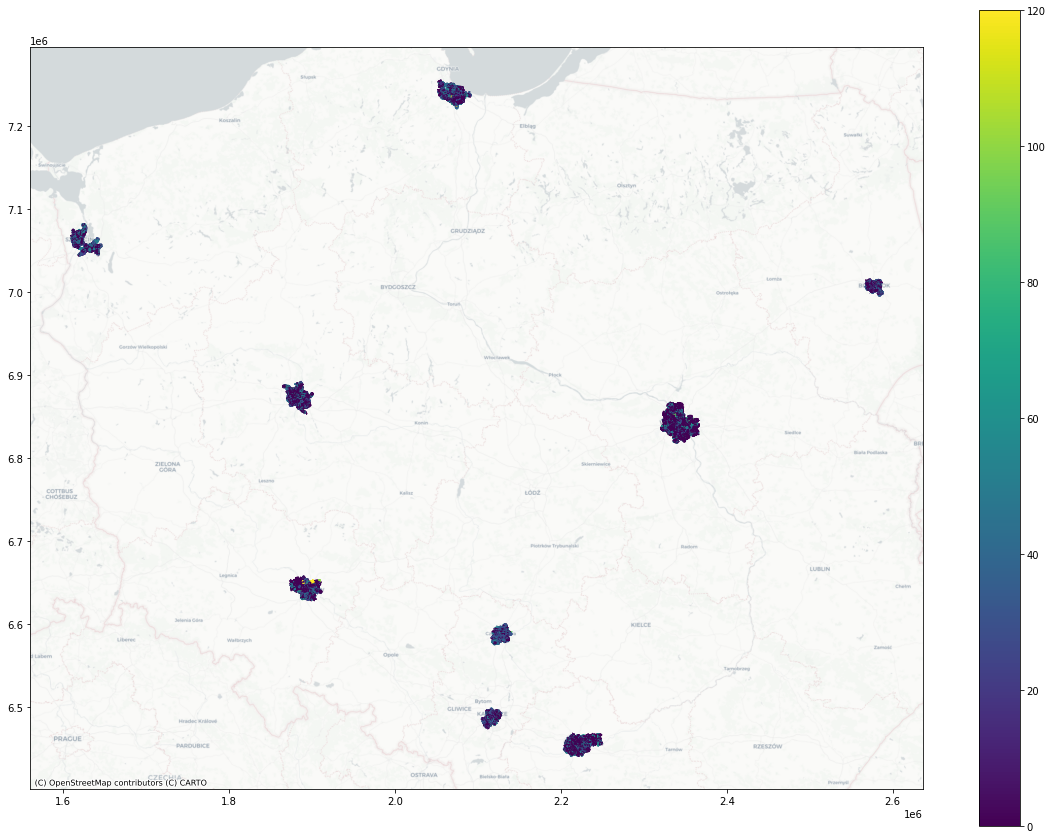

In [11]:
column_name = "maxspeed"

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set_aspect('equal')
df_agg.to_crs(epsg=3857).plot(ax=ax, column=column_name, alpha=1, legend=True, linewidth=3)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)